Found 292 files belonging to 3 classes.

Evaluating model: xception_finetuned_top132.keras


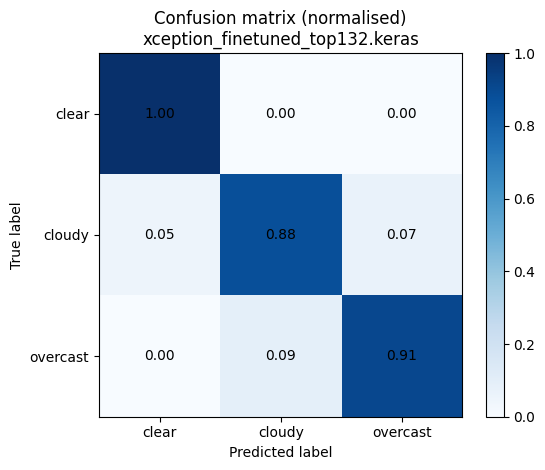


Evaluating model: xception_finetuned_top44.keras


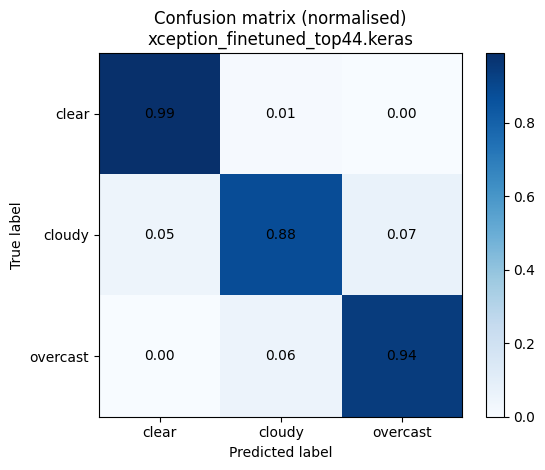


Evaluating model: xception_finetuned_top88.keras


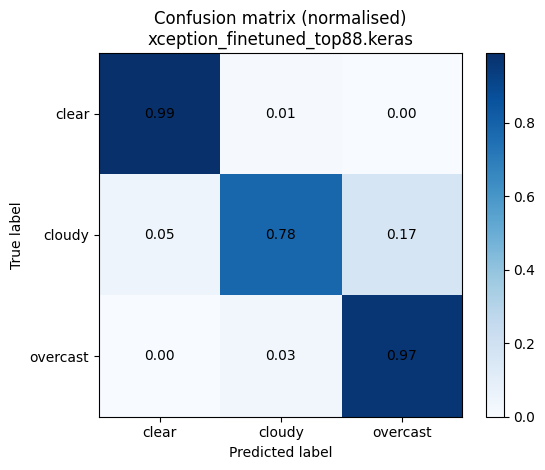


Evaluating model: xception_head_best.keras


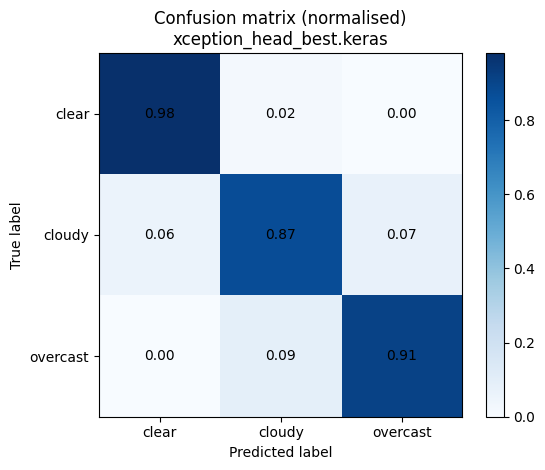


Summary of test metrics:


,model,test_loss,test_acc,macro_precision,macro_recall,macro_f1
0,xception_finetuned_top132.keras,0.154477,0.931507,0.930257,0.930093,0.929860
1,xception_finetuned_top44.keras,0.172675,0.938356,0.937445,0.938220,0.937392
2,xception_finetuned_top88.keras,0.238614,0.910959,0.912804,0.912793,0.908287
3,xception_head_best.keras,0.198091,0.921233,0.920475,0.920320,0.920204


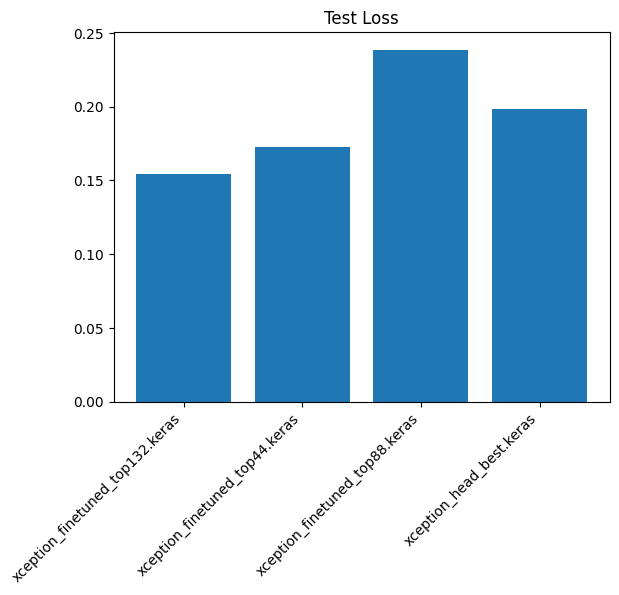

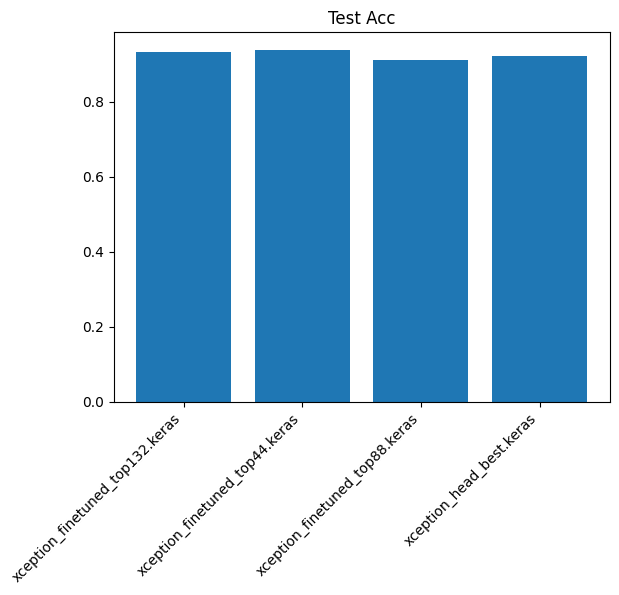

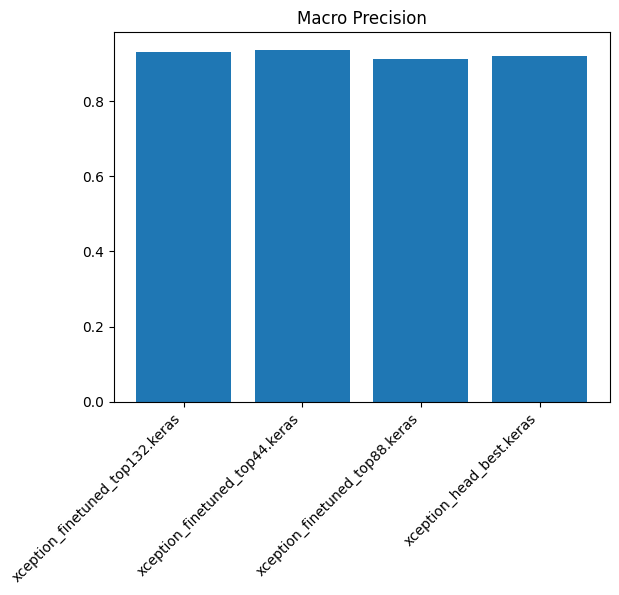

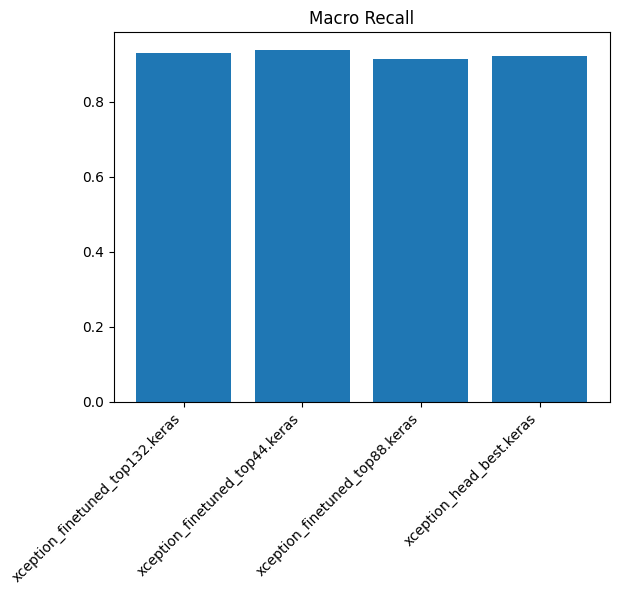

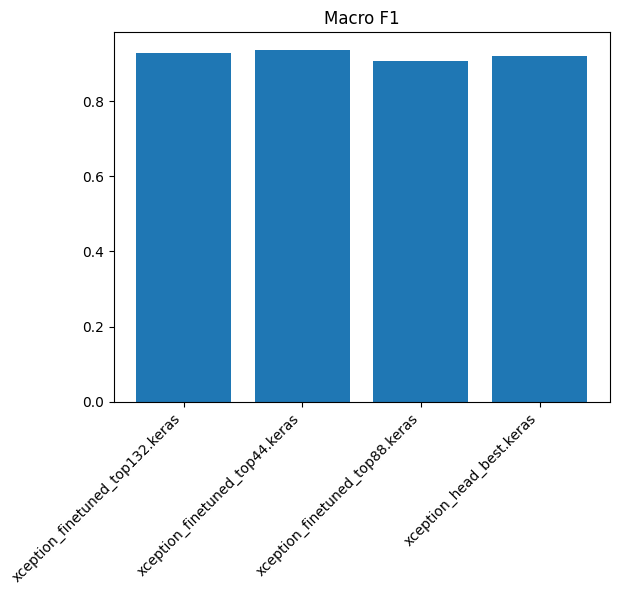

In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

import matplotlib.pyplot as plt
import pandas as pd

# -------------------------
# CONFIGS
# -------------------------
CLASS_NAMES = ["clear", "cloudy", "overcast"]
IMG_SIZE    = (299, 299)
BATCH_SIZE  = 32

MODEL_DIR   = "models"     # folder where the .keras files are
TEST_DIR    = "data/dataset/test"

# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

NUM_CLASSES = len(CLASS_NAMES)

# --- RELOAD evaluation metrics since model needs to be recompiled ----
class MacroPrecision(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="precision", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.conf_mat = self.add_weight(
            name="conf_mat",
            shape=(num_classes, num_classes),
            initializer="zeros",
            dtype=self.dtype
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_pred = tf.argmax(y_pred, axis=-1)
        y_pred = tf.cast(tf.reshape(y_pred, [-1]), tf.int32)

        cm = tf.math.confusion_matrix(
            y_true, y_pred,
            num_classes=self.num_classes,
            dtype=self.dtype
        )
        self.conf_mat.assign_add(cm)

    def result(self):
        tp = tf.linalg.diag_part(self.conf_mat)
        fp = tf.reduce_sum(self.conf_mat, axis=0) - tp
        precision_per_class = tp / (tp + fp + 1e-7)
        return tf.reduce_mean(precision_per_class)

    def reset_state(self):
        self.conf_mat.assign(tf.zeros_like(self.conf_mat))


class MacroRecall(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="recall", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.conf_mat = self.add_weight(
            name="conf_mat",
            shape=(num_classes, num_classes),
            initializer="zeros",
            dtype=self.dtype
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_pred = tf.argmax(y_pred, axis=-1)
        y_pred = tf.cast(tf.reshape(y_pred, [-1]), tf.int32)

        cm = tf.math.confusion_matrix(
            y_true, y_pred,
            num_classes=self.num_classes,
            dtype=self.dtype
        )
        self.conf_mat.assign_add(cm)

    def result(self):
        tp = tf.linalg.diag_part(self.conf_mat)
        fn = tf.reduce_sum(self.conf_mat, axis=1) - tp
        recall_per_class = tp / (tp + fn + 1e-7)
        return tf.reduce_mean(recall_per_class)

    def reset_state(self):
        self.conf_mat.assign(tf.zeros_like(self.conf_mat))


class MacroF1(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.conf_mat = self.add_weight(
            name="conf_mat",
            shape=(num_classes, num_classes),
            initializer="zeros",
            dtype=self.dtype
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_pred = tf.argmax(y_pred, axis=-1)
        y_pred = tf.cast(tf.reshape(y_pred, [-1]), tf.int32)

        cm = tf.math.confusion_matrix(
            y_true, y_pred,
            num_classes=self.num_classes,
            dtype=self.dtype
        )
        self.conf_mat.assign_add(cm)

    def result(self):
        tp = tf.linalg.diag_part(self.conf_mat)
        fp = tf.reduce_sum(self.conf_mat, axis=0) - tp
        fn = tf.reduce_sum(self.conf_mat, axis=1) - tp

        precision_per_class = tp / (tp + fp + 1e-7)
        recall_per_class    = tp / (tp + fn + 1e-7)

        f1_per_class = 2 * precision_per_class * recall_per_class / (
            precision_per_class + recall_per_class + 1e-7
        )
        return tf.reduce_mean(f1_per_class)

    def reset_state(self):
        self.conf_mat.assign(tf.zeros_like(self.conf_mat))


class ConfusionMatrixCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_ds, class_names):
        super().__init__()
        self.val_ds = val_ds
        self.class_names = class_names

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        # Loop over validation dataset
        for images, labels in self.val_ds:
            preds = self.model.predict(images, verbose=0)
            preds = np.argmax(preds, axis=1)

            y_true.extend(labels.numpy())
            y_pred.extend(preds)

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        print("\nConfusion Matrix:")
        print(cm)

        # Optional: also print class-by-class accuracy
        class_acc = cm.diagonal() / cm.sum(axis=1)
        for cname, acc in zip(self.class_names, class_acc):
            print(f"  {cname}: {acc:.3f}")


precision_metric = MacroPrecision(NUM_CLASSES)
recall_metric    = MacroRecall(NUM_CLASSES)
f1_metric        = MacroF1(NUM_CLASSES)


# Collect true labels 
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# -----------------------------------
# LOOP OVER ALL MODELS IN FOLDER
# -----------------------------------
results = []
cms = {}        # to store confusion matrices per model

model_files = sorted(
    [f for f in os.listdir(MODEL_DIR) if f.endswith(".keras")]
)

for fname in model_files:
    model_path = os.path.join(MODEL_DIR, fname)
    print("\n" + "=" * 80)
    print(f"Evaluating model: {fname}")
    print("=" * 80)

    # load model
    model = keras.models.load_model(model_path, compile=False)

    # predictions
    y_prob = model.predict(test_ds, verbose=0)
    y_pred = y_prob.argmax(axis=1)

    # --- METRICS ----
    # accuracy
    test_acc = (y_pred == y_true).mean()
    
    # loss 
    test_loss = tf.keras.losses.CategoricalCrossentropy()(
        tf.one_hot(y_true, depth=NUM_CLASSES),
        y_prob
    ).numpy()

    macro_precision = precision_score(y_true, y_pred, average="macro")
    macro_recall    = recall_score(y_true, y_pred, average="macro")
    macro_f1        = f1_score(y_true, y_pred, average="macro")

    results.append({
        "model": fname,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1,
    })

    # confusion matrix (normalised)
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    cms[fname] = (cm, cm_norm)

    # -----------------------------------
    # PLOT CONFUSION MATRIX PER MODEL
    # -----------------------------------
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm, cmap="Blues")
    plt.title(f"Confusion matrix (normalised)\n{fname}")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    ax.set_xticks(range(len(CLASS_NAMES)))
    ax.set_yticks(range(len(CLASS_NAMES)))
    ax.set_xticklabels(CLASS_NAMES)
    ax.set_yticklabels(CLASS_NAMES)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(
                j, i,
                f"{cm_norm[i, j]:.2f}",
                ha="center", va="center",
            )

    plt.tight_layout()
    plt.show()

# --------------------------------
# SUMMARY OF TEST METRICS
# --------------------------------
df_results = pd.DataFrame(results)
print("\nSummary of test metrics:")
display(df_results)

# --------------------------------
# PLOTS FOR EACH METRIC
# --------------------------------
metrics_to_plot = ["test_loss", "test_acc",
                   "macro_precision", "macro_recall", "macro_f1"]

for metric in metrics_to_plot:
    plt.figure()
    plt.bar(df_results["model"], df_results[metric])
    plt.title(metric.replace("_", " ").title())
    plt.xticks(rotation=45, ha="right")